In [1]:
import numpy as np
import snntorch as snn
import torch
from snntorch import spikegen
from snntorch import utils
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from snntorch import spikeplot as splt
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import itertools

from snntorch import surrogate
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [2]:
class _SpikeTensor(torch.Tensor):
    """Inherits from torch.Tensor with additional attributes.
    ``init_flag`` is set at the time of initialization.
    When called in the forward function of any neuron, they are parsed and
    replaced with a torch.Tensor variable.
    """

    @staticmethod
    def __new__(cls, *args, init_flag=False, **kwargs):
        return super().__new__(cls, *args, **kwargs)

    def __init__(
        self,
        *args,
        init_flag=True,
    ):
        # super().__init__() # optional
        self.init_flag = init_flag


def _SpikeTorchConv(*args, input_):
    """Convert SpikeTensor to torch.Tensor of the same size as ``input_``."""

    states = []
    # if len(input_.size()) == 0:
    #     _batch_size = 1  # assume batch_size=1 if 1D input
    # else:
    #     _batch_size = input_.size(0)
    if (
        len(args) == 1 and type(args) is not tuple
    ):  # if only one hidden state, make it iterable
        args = (args,)
    for arg in args:
        arg = arg.to("cpu")
        arg = torch.Tensor(arg)  # wash away the SpikeTensor class
        arg = torch.zeros_like(input_, requires_grad=True)
        states.append(arg)
    if len(states) == 1:  # otherwise, list isn't unpacked
        return states[0]

    return states


In [ ]:
# file = open("Arthymia_4_para.csv")

# num_steps = 10
# batch_size = 100
# num_epochs = 170
# loss_hist = []
# test_loss_hist = []
# counter = 0
# num_inputs = 1*4
# num_hidden = 9
# num_outputs = 7
# learning_rate = 2e-3
# torch.manual_seed(490) 
# dtype = torch.float       # 93.07

# file = open("Arthymia_4_para.csv")

num_steps = 10
batch_size = 100
num_epochs = 165
loss_hist = []
test_loss_hist = []
counter = 0
num_inputs = 1*3
num_hidden = 15
num_outputs = 7
learning_rate = 1e-3
torch.manual_seed(500) 
dtype = torch.float #          85%

In [4]:
df = pd.read_excel("ECG_3_5.xlsx")
df = df[df['Type'] != "[0]"]
df.dropna(inplace=True)
df["Type"].value_counts()

N    540
A    137
R     43
V     28
S      8
Name: Type, dtype: int64

In [5]:
from imblearn.over_sampling import SMOTE
X = df.drop(columns=['Type'])
y = df['Type']

smote = SMOTE(sampling_strategy={'N': 2000, 'A': 2000, 'R': 2000, 'V': 2000, 'S': 1000}, random_state=42)  # 'auto' balances classes

# Generate synthetic samples
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine resampled data into a DataFrame
resampled_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Type'])], axis=1)

# Now resampled_df contains your oversampled dataset with balanced classes
resampled_df["Type"].value_counts()

N    2000
V    2000
A    2000
R    2000
S    1000
Name: Type, dtype: int64

In [6]:
ip_features = resampled_df.iloc[:, :3].values
scaler = StandardScaler()
scaler.fit(ip_features)

normalized_input_features = scaler.transform(ip_features)
normalized_input_features

array([[-0.58119015, -0.71584574,  0.69863813],
       [-0.59861585, -0.51343608,  0.69863813],
       [-0.57211282, -1.09961876,  0.69863813],
       ...,
       [ 0.21398356, -0.19263464, -1.43135617],
       [-0.44633827,  2.41899408, -1.43135617],
       [-0.43348161,  2.39763317, -1.43135617]])

In [7]:
print(scaler.mean_)
print(scaler.var_)

[8.50978795e+02 1.33005256e+02 6.72000000e-01]
[3.31960901e+05 8.67281764e+03 2.20416000e-01]


In [8]:
# X = resampled_df[["0_pre-RR", "0_qrs_interval", "0_qt_interval", "0_st_interval"]]
y = resampled_df["Type"].map({"N": 0, "V": 1, "S": 2, "A": 3, "R":4})
# input_data = np.array(X)
input_data = np.array(normalized_input_features)
input_data

array([[-0.58119015, -0.71584574,  0.69863813],
       [-0.59861585, -0.51343608,  0.69863813],
       [-0.57211282, -1.09961876,  0.69863813],
       ...,
       [ 0.21398356, -0.19263464, -1.43135617],
       [-0.44633827,  2.41899408, -1.43135617],
       [-0.43348161,  2.39763317, -1.43135617]])

In [9]:
output_data = np.array(y)
output_data

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [10]:
from sklearn.model_selection import train_test_split

inputs_tensor = torch.tensor(input_data, dtype=torch.float32)
outputs_tensor = torch.tensor(output_data, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(
    inputs_tensor, outputs_tensor, train_size=0.7, random_state=1
)

dataset_train = TensorDataset(X_train, y_train)
dataset_test = TensorDataset(X_test, y_test)

data_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)


In [11]:
print(inputs_tensor)
print(outputs_tensor)

tensor([[-0.5812, -0.7158,  0.6986],
        [-0.5986, -0.5134,  0.6986],
        [-0.5721, -1.0996,  0.6986],
        ...,
        [ 0.2140, -0.1926, -1.4314],
        [-0.4463,  2.4190, -1.4314],
        [-0.4335,  2.3976, -1.4314]])
tensor([0, 0, 0,  ..., 1, 1, 1])


In [12]:
class SpikingNeuron(nn.Module):
    """Parent class for spiking neuron models."""

    instances = []
    """Each :mod:`snntorch.SpikingNeuron` neuron
    (e.g., :mod:`snntorch.Synaptic`) will populate the
    :mod:`snntorch.SpikingNeuron.instances` list with a new entry.
    The list is used to initialize and clear neuron states when the
    argument `init_hidden=True`."""

    reset_dict = {
        "subtract": 0,
        "zero": 1,
        "none": 2,
    }

    def __init__(
        self,
        threshold=1.0,
        spike_grad=None,
        surrogate_disable=False,
        init_hidden=False,
        inhibition=False,
        learn_threshold=False,
        reset_mechanism="subtract",
        state_quant=False,
        output=False,
        graded_spikes_factor=1.0,
        learn_graded_spikes_factor=False,
    ):
        super(SpikingNeuron, self).__init__()

        SpikingNeuron.instances.append(self)
        self.init_hidden = init_hidden
        self.inhibition = inhibition
        self.output = output
        self.surrogate_disable = surrogate_disable

        self._snn_cases(reset_mechanism, inhibition)
        self._snn_register_buffer(
            threshold=threshold,
            learn_threshold=learn_threshold,
            reset_mechanism=reset_mechanism,
            graded_spikes_factor=graded_spikes_factor,
            learn_graded_spikes_factor=learn_graded_spikes_factor,
        )
        self._reset_mechanism = reset_mechanism

        if spike_grad is None:
            self.spike_grad = self.ATan.apply
        else:
            self.spike_grad = spike_grad

        if self.surrogate_disable:
            self.spike_grad = self._surrogate_bypass

        self.state_quant = state_quant

    def fire(self, mem):
        """Generates spike if mem > threshold.
        Returns spk."""

        if self.state_quant:
            mem = self.state_quant(mem)

        mem_shift = mem - self.threshold
        spk = self.spike_grad(mem_shift)

        spk = spk * self.graded_spikes_factor

        return spk

    def fire_inhibition(self, batch_size, mem):
        """Generates spike if mem > threshold, only for the largest membrane.
        All others neurons will be inhibited for that time step.
        Returns spk."""
        mem_shift = mem - self.threshold
        index = torch.argmax(mem_shift, dim=1)
        spk_tmp = self.spike_grad(mem_shift)

        mask_spk1 = torch.zeros_like(spk_tmp)
        mask_spk1[torch.arange(batch_size), index] = 1
        spk = spk_tmp * mask_spk1
        # reset = spk.clone().detach()

        return spk

    def mem_reset(self, mem):
        """Generates detached reset signal if mem > threshold.
        Returns reset."""
        mem_shift = mem - self.threshold
        reset = self.spike_grad(mem_shift).clone().detach()

        return reset

    def _snn_cases(self, reset_mechanism, inhibition):
        self._reset_cases(reset_mechanism)

        if inhibition:
            warn(
                "Inhibition is an unstable feature that has only been tested "
                "for dense (fully-connected) layers. Use with caution!",
                UserWarning,
            )

    def _reset_cases(self, reset_mechanism):
        if (
            reset_mechanism != "subtract"
            and reset_mechanism != "zero"
            and reset_mechanism != "none"
        ):
            raise ValueError(
                "reset_mechanism must be set to either 'subtract', "
                "'zero', or 'none'."
            )

    def _snn_register_buffer(
        self,
        threshold,
        learn_threshold,
        reset_mechanism,
        graded_spikes_factor,
        learn_graded_spikes_factor,
    ):
        """Set variables as learnable parameters else register them in the
        buffer."""

        self._threshold_buffer(threshold, learn_threshold)
        self._graded_spikes_buffer(
            graded_spikes_factor, learn_graded_spikes_factor
        )

        # reset buffer
        try:
            # if reset_mechanism_val is loaded from .pt, override
            # reset_mechanism
            if torch.is_tensor(self.reset_mechanism_val):
                self.reset_mechanism = list(SpikingNeuron.reset_dict)[
                    self.reset_mechanism_val
                ]
        except AttributeError:
            # reset_mechanism_val has not yet been created, create it
            self._reset_mechanism_buffer(reset_mechanism)

    def _graded_spikes_buffer(
        self, graded_spikes_factor, learn_graded_spikes_factor
    ):
        if not isinstance(graded_spikes_factor, torch.Tensor):
            graded_spikes_factor = torch.as_tensor(graded_spikes_factor)
        if learn_graded_spikes_factor:
            self.graded_spikes_factor = nn.Parameter(graded_spikes_factor)
        else:
            self.register_buffer("graded_spikes_factor", graded_spikes_factor)

    def _threshold_buffer(self, threshold, learn_threshold):
        if not isinstance(threshold, torch.Tensor):
            threshold = torch.as_tensor(threshold)
        if learn_threshold:
            self.threshold = nn.Parameter(threshold)
        else:
            self.register_buffer("threshold", threshold)

    def _reset_mechanism_buffer(self, reset_mechanism):
        """Assign mapping to each reset mechanism state.
        Must be of type tensor to store in register buffer. See reset_dict
        for mapping."""
        reset_mechanism_val = torch.as_tensor(
            SpikingNeuron.reset_dict[reset_mechanism]
        )
        self.register_buffer("reset_mechanism_val", reset_mechanism_val)

    def _V_register_buffer(self, V, learn_V):
        if not isinstance(V, torch.Tensor):
            V = torch.as_tensor(V)
        if learn_V:
            self.V = nn.Parameter(V)
        else:
            self.register_buffer("V", V)

    @property
    def reset_mechanism(self):
        """If reset_mechanism is modified, reset_mechanism_val is triggered
        to update.
        0: subtract, 1: zero, 2: none."""
        return self._reset_mechanism

    @reset_mechanism.setter
    def reset_mechanism(self, new_reset_mechanism):
        self._reset_cases(new_reset_mechanism)
        self.reset_mechanism_val = torch.as_tensor(
            SpikingNeuron.reset_dict[new_reset_mechanism]
        )
        self._reset_mechanism = new_reset_mechanism

    @classmethod
    def init(cls):
        """Removes all items from :mod:`snntorch.SpikingNeuron.instances`
        when called."""
        cls.instances = []

    @staticmethod
    def detach(*args):
        """Used to detach input arguments from the current graph.
        Intended for use in truncated backpropagation through time where
        hidden state variables are global variables."""
        for state in args:
            state.detach_()

    @staticmethod
    def zeros(*args):
        """Used to clear hidden state variables to zero.
        Intended for use where hidden state variables are global variables."""
        for state in args:
            state = torch.zeros_like(state)

    @staticmethod
    def _surrogate_bypass(input_):
        return (input_ > 0).float()

    @staticmethod
    class ATan(torch.autograd.Function):
        """
        Surrogate gradient of the Heaviside step function.

        **Forward pass:** Heaviside step function shifted.

            .. math::

                S=\\begin{cases} 1 & \\text{if U ≥ U$_{\\rm thr}$} \\\\
                0 & \\text{if U < U$_{\\rm thr}$}
                \\end{cases}

        **Backward pass:** Gradient of shifted arc-tan function.

            .. math::

                    S&≈\\frac{1}{π}\\text{arctan}(πU \\frac{α}{2}) \\\\
                    \\frac{∂S}{∂U}&=\\frac{1}{π}\
                    \\frac{1}{(1+(πU\\frac{α}{2})^2)}


        :math:`alpha` defaults to 2, and can be modified by calling
        ``surrogate.atan(alpha=2)``.

        Adapted from:

        *W. Fang, Z. Yu, Y. Chen, T. Masquelier, T. Huang, Y. Tian (2021)
        Incorporating Learnable Membrane Time Constants to Enhance Learning
        of Spiking Neural Networks. Proc. IEEE/CVF Int. Conf. Computer
        Vision (ICCV), pp. 2661-2671.*"""

        @staticmethod
        def forward(ctx, input_, alpha=2.0):
            ctx.save_for_backward(input_)
            ctx.alpha = alpha
            out = (input_ > 0).float()
            return out

        @staticmethod
        def backward(ctx, grad_output):
            (input_,) = ctx.saved_tensors
            grad_input = grad_output.clone()
            grad = (
                ctx.alpha
                / 2
                / (1 + (torch.pi / 2 * ctx.alpha * input_).pow_(2))
                * grad_input
            )
            return grad, None


In [13]:
class AdEx(SpikingNeuron):

    def __init__(
        self, Cm, g_L, E_L, Delta_T, V_T, a, tau_w,
        threshold=1.0,
        spike_grad=None,
        surrogate_disable=False,
        init_hidden=False,
        inhibition=False,
        learn_beta=False,
        learn_threshold=False,
        reset_mechanism="subtract",
        state_quant=False,
        output=False,
        graded_spikes_factor=1.0,
        learn_graded_spikes_factor=False,
    ):
        super().__init__(
            threshold,
            spike_grad,
            surrogate_disable,
            init_hidden,
            inhibition,
            learn_threshold,
            reset_mechanism,
            state_quant,
            output,
            graded_spikes_factor,
            learn_graded_spikes_factor,
        )

        self.spike_gradient = self.ATan.apply
        self.Cm = Cm            # Membrane capacitance
        self.g_L = g_L          # Leak conductance
        self.E_L = E_L          # Leak reversal potential
        self.Delta_T = Delta_T  # Slope factor
        self.V_T = V_T          # Spike threshold
        self.a = a              # Subthreshold adaptation parameter
        self.tau_w = tau_w      # Adaptation time constant
        self.w = torch.tensor(0.0)         # Initial adaptation current
        
        if self.init_hidden:
            self.mem = self.init_leaky()

    def forward(self, input_, mem=False):

        if hasattr(mem, "init_flag"):  # only triggered on first-pass
            mem = _SpikeTorchConv(mem, input_=input_)
        elif mem is False and hasattr(
            self.mem, "init_flag"
        ):  # init_hidden case
            
            self.mem = _SpikeTorchConv(self.mem, input_=input_)
 
        dt = 0.1
        spk = self.spike_gradient((mem - self.V_T))  # call the Heaviside function

        dV = (self.g_L * (self.E_L - mem) + self.g_L * self.Delta_T * torch.exp((mem - self.V_T) / self.Delta_T) - self.w + abs(input_)) / self.Cm
        dw = (self.a * (mem - self.E_L) - self.w) / self.tau_w

        mem = mem + dV * dt  # Avoid in-place modification
        self.w = self.w + dw * dt  # Avoid in-place modification

        spike_mask = mem >= 0  # Spike condition
        mem = torch.where(spike_mask, torch.tensor(float(self.E_L)), mem)  # Reset membrane potential where spike occurs
        self.w = self.w + 2 * spike_mask.float()  # Spike-triggered adaptation

        return spk, mem

    
    @staticmethod
    def init_AdEx():
        """
        Used to initialize mem as an empty SpikeTensor.
        ``init_flag`` is used as an attribute in the forward pass to convert
        the hidden states to the same as the input.
        """
        mem = _SpikeTensor(init_flag=False)

        return mem

In [14]:
Cm = 200   # Membrane capacitance (200 pF)
g_L = 10    # Leak conductance (10 nS)
E_L = -70   # Leak reversal potential (-70 mV)
Delta_T = 10 # Slope factor (2 mV)
V_T = -50   # Spike threshold (-50 mV)
a = 2       # Subthreshold adaptation parameter (2 nS)
tau_w = 30  # Adaptation time constant (30 ms)

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.adex1 = AdEx(Cm, g_L, E_L, Delta_T, V_T, a, tau_w)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.adex2 = AdEx(Cm, g_L, E_L, Delta_T, V_T, a, tau_w)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.adex1.init_AdEx()
        mem2 = self.adex2.init_AdEx()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.adex1(cur1*10000, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.adex2(cur2*10000, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
net = Net().to(device)

In [16]:

test_accuracy_data = []
train_accuracy_data = []

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
        train_accuracy_data.append(acc*100)
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")
        test_accuracy_data.append(acc*100)

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [17]:
loss = nn.CrossEntropyLoss()
#dice, hinge
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))

In [18]:
data, targets = next(iter(data_loader))
data = data.to(device)
targets = targets.to(device)

In [19]:
spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())

torch.Size([10, 100, 7])


In [20]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 35.352
Train set accuracy for a single minibatch: 26.00%


In [21]:
# Outer training loop
# torch.autograd.set_detect_anomaly(True)

for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(data_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        # print(data.shape)
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(data_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 5 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 36.00
Test Set Loss: 35.71
Train set accuracy for a single minibatch: 19.00%
Test set accuracy for a single minibatch: 32.00%


Epoch 0, Iteration 5
Train Set Loss: 31.81
Test Set Loss: 31.51
Train set accuracy for a single minibatch: 17.00%
Test set accuracy for a single minibatch: 24.00%


Epoch 0, Iteration 10
Train Set Loss: 30.76
Test Set Loss: 30.13
Train set accuracy for a single minibatch: 27.00%
Test set accuracy for a single minibatch: 20.00%


Epoch 0, Iteration 15
Train Set Loss: 27.23
Test Set Loss: 30.13
Train set accuracy for a single minibatch: 18.00%
Test set accuracy for a single minibatch: 23.00%


Epoch 0, Iteration 20
Train Set Loss: 26.88
Test Set Loss: 25.63
Train set accuracy for a single minibatch: 21.00%
Test set accuracy for a single minibatch: 25.00%


Epoch 0, Iteration 25
Train Set Loss: 24.95
Test Set Loss: 25.74
Train set accuracy for a single minibatch: 20.00%
Test set accuracy for a single minibatch: 25.00%


Epoch 

In [22]:
num_epochs = 100

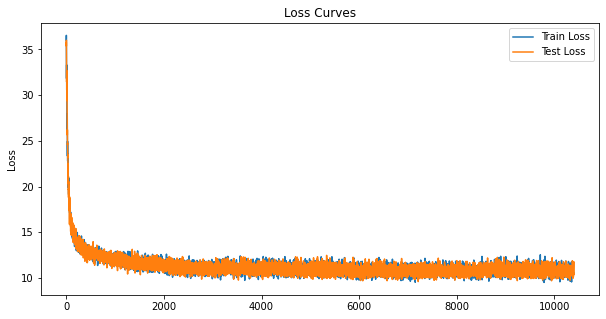

In [23]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.ylabel("Loss")
plt.show()

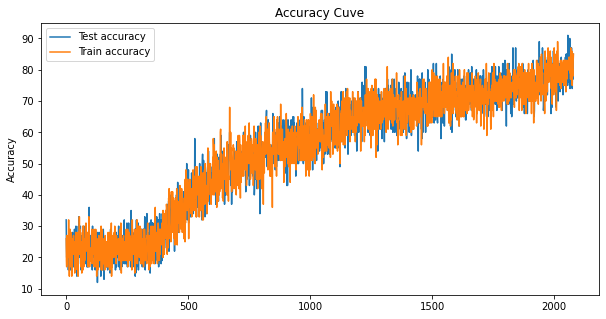

In [24]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(test_accuracy_data)
plt.plot(train_accuracy_data)
plt.title("Accuracy Cuve")
plt.legend(["Test accuracy", "Train accuracy"])
plt.ylabel("Accuracy")
plt.show()

In [25]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)
    
    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set : {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set : 2160/2700
Test Set Accuracy: 80.00%


In [26]:
conf_matrix = confusion_matrix(targets, predicted)

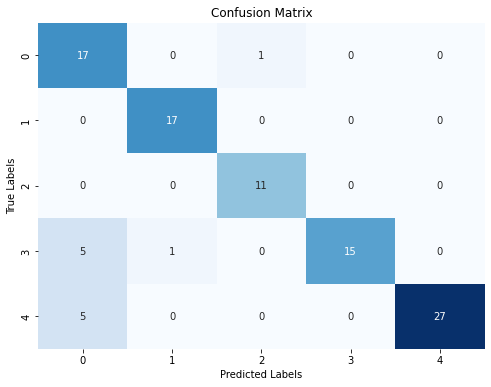

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [29]:
# Calculating specificity for each class
num_classes = len(conf_matrix)
specificity = np.zeros(num_classes)

for i in range(num_classes):
    # True negatives for the current class
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    
    # False positives for other classes
    fp = np.sum(np.delete(conf_matrix[i, :], i))
    
    # Specificity for the current class
    specificity[i] = tn / (tn + fp)

print("Confusion Matrix:")
print(conf_matrix)
print(specificity)

Confusion Matrix:
[[17  0  1  0  0]
 [ 0 17  0  0  0]
 [ 0  0 11  0  0]
 [ 5  1  0 15  0]
 [ 5  0  0  0 27]]
[0.98611111 1.         1.         0.92857143 0.93055556]
